In [19]:
!pip install fuzzywuzzy

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import altair as alt
import pandas as pd

from datetime import datetime

In [2]:
path_ru = 'wikipedia/ru_holdout.csv'
ru_wiki_path = 'wikipedia/ru_wiki_changed_df.csv'

In [3]:
import pandas as pd

ru_df = pd.read_csv(path_ru)
ruwiki_df = pd.read_csv(ru_wiki_path)

In [4]:
# Proper arrays fields

import ast

ruwiki_fields = ['lines_added', 'lines_changed', 'lines_deleted']
wiki_fields = ['texts_insert', 'texts_removed', 'texts_change']

for line in ruwiki_fields:
    ruwiki_df[line] = ruwiki_df[line].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

for line in wiki_fields:
    # ua_df[line] = ua_df[line].apply(
    #     lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    # )
    ru_df[line] = ru_df[line].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

ruwiki_df['texts_insert'] = ruwiki_df['lines_added']
ruwiki_df['texts_removed'] = ruwiki_df['lines_deleted']
ruwiki_df['texts_change'] = ruwiki_df['lines_changed']
ruwiki_df['page_title'] = ruwiki_df['page_name']

In [5]:
print('RWF length: ', len(ruwiki_df))
print('RW length: ', len(ru_df))
# print('UW length: ', len(ua_df))

RWF length:  33664
RW length:  2341298


#### Texts analysis

In [6]:
# ua_text = ua_df[ua_df.apply(
#     lambda x: len(x['texts_insert']) > 0 or len(x['texts_removed']) > 0 or len(x['texts_change']) > 0, axis=1
# )][['page_title', 'texts_insert', 'texts_removed', 'texts_change', 'revision_is_identity_reverted']]

# ua_text['texts_removed'] = ua_text['texts_removed'].apply(lambda x: x if isinstance(x, list) else [])
# ua_text['texts_insert'] = ua_text['texts_insert'].apply(lambda x: x if isinstance(x, list) else [])
# ua_text['is_reverted'] = ua_text['revision_is_identity_reverted']

# print(len(ua_text))

In [7]:
fork_text = ruwiki_df[ruwiki_df.apply(
    lambda x: len(x['texts_insert']) > 0 or len(x['texts_removed']) > 0 or len(x['texts_change']) > 0, axis=1
)][['page_title', 'texts_insert', 'texts_removed', 'texts_change']]

fork_text['texts_removed'] = fork_text['texts_removed'].apply(lambda x: x if isinstance(x, list) else [])
fork_text['texts_insert'] = fork_text['texts_insert'].apply(lambda x: x if isinstance(x, list) else [])
fork_text['is_reverted'] = 0

print(len(fork_text))

18520


In [8]:
ru_text = ru_df[ru_df.apply(
    lambda x: any(str(item).strip() for item in x['texts_insert']) or
                any(str(item).strip() for item in x['texts_removed']), axis=1
)][['page_title', 'revision_id', 'texts_insert', 'texts_removed', 'texts_change', 'revision_is_identity_reverted',
   'event_user_text_historical']]
ru_text.head()

ru_text['texts_removed'] = ru_text['texts_removed'].apply(lambda x: x if isinstance(x, list) else [])
ru_text['texts_insert'] = ru_text['texts_insert'].apply(lambda x: x if isinstance(x, list) else [])
ru_text['is_reverted'] = ru_text['revision_is_identity_reverted']
ru_text['user'] = ru_text['event_user_text_historical']

print(len(ru_text))

1195775


lines_changed:
A list of sentence pairs representing changes made in RuWiki compared to Wikipedia.

The first element of each pair is the original sentence from Wikipedia.
The second element is the modified sentence from RuWiki.

In [9]:
from tqdm import tqdm

for idx, line in tqdm(ru_text.iterrows(), total=ru_text.shape[0]):
    change = line['texts_change']
    for ch in change:
        if ch[0] not in line['texts_removed']: line['texts_removed'].append(ch[0])
        if ch[1] not in line['texts_insert']: line['texts_insert'].append(ch[1])

100%|██████████| 1195775/1195775 [00:37<00:00, 32281.01it/s]


In [10]:
len(set(ru_text['revision_id']))

1195775

In [11]:
ru_text['text_insert_joined'] = ru_text.apply(lambda line: ''.join(line['texts_insert']), axis=1)

In [12]:
ru_text['texts_removed_joined'] = ru_text.apply(lambda line: ''.join(''.join(str(el) for el in line['texts_removed'])) if len(line['texts_removed']) else '', axis=1)

In [13]:
ru_text[['page_title', 'revision_id', 'text_insert_joined', 'texts_removed_joined', 'is_reverted', 'user']]

,page_title,revision_id,text_insert_joined,texts_removed_joined,is_reverted,user
1,Газлайтинг,125799865,,Хватит преследовать своих граждан и держать их...,0,Lesless
2,Всеобщая_забастовка_в_Швеции_(1909),125824728,26 июля 1909 года локаут хватил деревообрабаты...,Оборонительную тактика конфедерации была не по...,0,Роман Сергеевич Сидоров
4,5_октября,125857872,,"2022 — Путин Владимир (р1952), президент России.",0,EstherColeman
5,Улица_Мира_(Казань),125860407,Часть Сибирского тракта,,0,Artem7154
6,Хамиль,125896350,В 2009 году снялся в клипе на совместную компо...,В 2009 году снялся в клипе на совместную компо...,0,95.181.53.38
...,...,...,...,...,...,...
2341285,Ахмад_Шах_Масуд,134912386,"\nПро Ахмада Шаха Масуда написана поэма ""Масъу...",,0,WuAiBu
2341289,Курдский_язык,135047618,В Иране и Азербайджане число тюркизированных к...,"В Турецкой Республике курдов, перешедших на ту...",0,Martin Jalali
2341292,Фантастика_(телешоу),135094668,Первый канал успел отснять финальные выпуски ш...,,0,Soskovalol
2341293,"Вайдель,_Алис",135113797,С сентября 2017 года совместно с Александром Г...,Совместно с Александром Гауландом была ведущим...,0,Dr.mabuse


In [14]:
for idx, line in tqdm(fork_text.iterrows(), total=fork_text.shape[0]):
    change = line['texts_change']
    for ch in change:
        if ch[0] not in line['texts_removed']: line['texts_removed'].append(ch[0])
        if ch[1] not in line['texts_insert']: line['texts_insert'].append(ch[1])

100%|██████████| 18520/18520 [00:00<00:00, 26786.90it/s]


In [15]:
fork_text['text_insert_joined'] = fork_text.apply(lambda line: ''.join(line['texts_insert']), axis=1)
fork_text['texts_removed_joined'] = fork_text.apply(lambda line: ''.join(''.join(str(el) for el in line['texts_removed'])) if len(line['texts_removed']) else '', axis=1)

In [16]:
fork_text[['page_title', 'text_insert_joined', 'texts_removed_joined']]

,page_title,text_insert_joined,texts_removed_joined
8,Железнодорожный (Нижегородская область),Проводной интернет предоставлен операторами Ро...,Кабельное телевидение предоставлено оператором...
12,Улица Чкалова (Мелитополь),"Улица Чкалова — улица на севере Мелитополя, ид...",Улица Чкалова (укрВулиця Чкалова) — улица на с...
17,Моленар,"Моленар, Брам (1961—2023) — программист, актив...","Моленар, Брам (род1961) — активный член сообще..."
19,"Чтак, Валерий Сергеевич","2015 — «Доброе утро, иностранцы», Triangle Gal...","2015 — «Доброе утро, иностранцы», Галерея «Tri..."
21,GSMA,Megafon PSSC (Мегафон) (Компания была исключен...,Megafon PSSC (Мегафон) (Компания была исключен...
...,...,...,...
33653,"Каноков, Арсен Баширович",16 декабря 2022 года включён в санкционный спи...,"16 декабря 2022 года, на фоне вторжения России..."
33654,Марихуана,,Курение марихуаны
33658,История административно-территориального делен...,По состоянию на 2022 год административно-терри...,По состоянию на 2022 год административно-терри...
33659,Катунь,У юго-западных окраин города Бийска сливается ...,Площадь бассейна — 60 900 км²Длина реки — 688 ...


In [17]:
fork_text.to_csv('fork_text_cleaned.csv')

#### Matching texts from RW and RWFork by Revision level (If small part of text matches, the whole revision will be marked as intersection with RWFork)

In [20]:
from fuzzywuzzy import fuzz, process

tqdm.pandas()

def get_match(text_row, row_name):
    text_array_1 = text_row[row_name]
    title = text_row['page_title']
    
    # print('text_array_1: ', text_array_1, 'title:   ', title)

    text_array_2 = fork_text.loc[fork_text['page_title'] == title, 'texts_insert'].tolist()
    text_array_2 = [str(item) for sublist in text_array_2 for item in (sublist if isinstance(sublist, list) else [sublist])]
    
    # print('text_array_2: ', text_array_2)
    
    if len(text_array_2):
        res = set()
        
        for el in text_array_1:
            if not isinstance(el, str):
                el = str(el)
            if not el or el.isdigit() or not any(c.isalnum() for c in el):
                # print(f"Skipping invalid query: '{el}'")
                continue
            if el.strip() and len(el.strip()) > 1:
                matches = process.extractBests(el, text_array_2, scorer=fuzz.partial_ratio, score_cutoff=70)
                if matches and len(matches[0][0]) > 3:
                    res.add(matches[0][0])
        
        return list(res) if res else None
    else:
        return None

/opt/conda/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [21]:
ru_text['insert_intersection_chunk'] = ru_text.progress_apply(get_match, row_name='texts_insert', axis=1)
ru_text['remove_intersection_chunk'] = ru_text.progress_apply(get_match, row_name='texts_removed', axis=1)

100%|██████████| 1195775/1195775 [33:10<00:00, 600.59it/s] 


In [22]:
ru_text.to_csv('ru_text_cleaned.csv')

In [23]:
print('Insert revisions intersections:', ru_text['insert_intersection_chunk'].notna().sum())
print('Remove revisions intersections:', ru_text['remove_intersection_chunk'].notna().sum())

Insert revisions intersections: 2627
Remove revisions intersections: 2493


In [24]:
fork_text = pd.read_csv('fork_text_cleaned.csv')
ru_text = pd.read_csv('ru_text_cleaned.csv')

In [25]:
titles = set(fork_text['page_title'])

selected_ru_text = ru_text[ru_text['page_title'].isin(titles)]
len(selected_ru_text)

15697

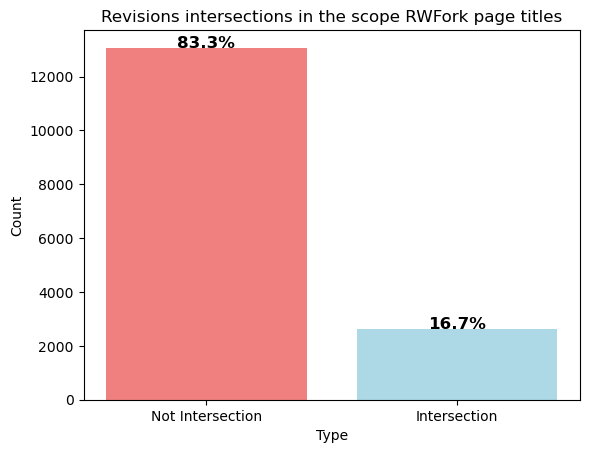

In [26]:
not_intersection_count = selected_ru_text['insert_intersection_chunk'].isna().sum()
intersection_count = selected_ru_text['insert_intersection_chunk'].notna().sum()

total_count = not_intersection_count + intersection_count


not_intersection_pct = (not_intersection_count / total_count) * 100
intersection_pct = (intersection_count / total_count) * 100


labels = ['Not Intersection', 'Intersection']
values = [not_intersection_count, intersection_count]

plt.bar(labels, values, color=['lightcoral', 'lightblue'])


for i, v in enumerate(values):
    plt.text(i, v + 10, f"{(v / total_count) * 100:.1f}%", ha='center', fontsize=12, fontweight='bold')


plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Revisions intersections in the scope RWFork page titles")

plt.show()

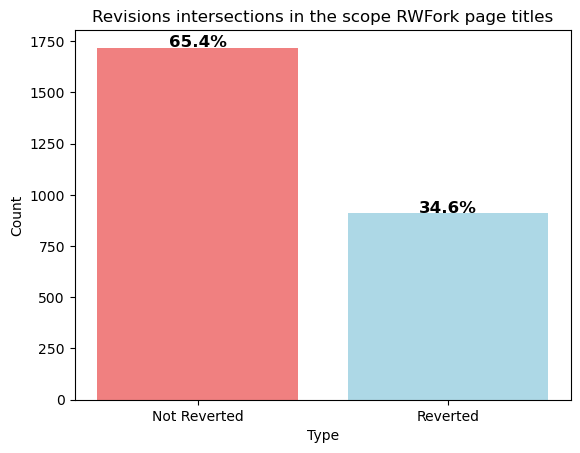

In [27]:
not_reverted_intersection_count = selected_ru_text[selected_ru_text['is_reverted'] == 0]['insert_intersection_chunk'].notna().sum()
reverted_intersection_count = selected_ru_text[selected_ru_text['is_reverted'] == 1]['insert_intersection_chunk'].notna().sum()

total_count = not_reverted_intersection_count + reverted_intersection_count

not_reverted_pct = (not_reverted_intersection_count / total_count) * 100
reverted_pct = (reverted_intersection_count / total_count) * 100


labels = ['Not Reverted', 'Reverted']
values = [not_reverted_intersection_count, reverted_intersection_count]

plt.bar(labels, values,  color=['lightcoral', 'lightblue'])

for i, v in enumerate(values):
    plt.text(i, v + 5, f"{(v / total_count) * 100:.1f}%", ha='center', fontsize=12, fontweight='bold')


plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Revisions intersections in the scope RWFork page titles")

plt.show()

#### Shifterator

Shifterator is a Python package for visualizing pairwise comparisons between texts through word shifts, a general method for extracting which words contribute to a difference between two texts and, importantly, how they do so. 

In [28]:
import re

# keep НА as it is an important part of the narrative about ignoring grammar
russian_stopwords = set(["и", "или", "изза", "его", "по", "из", "за", "в", "во", "не", "что", 
                         "он", "я", "с", "со", "как", "а", "то", "все", "она", "о"])

def clean_text(text):
    if pd.isna(text):
        return ""
    
    text = text.lower()
    text = re.sub(r"[^а-яё\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    words = text.split()
    words = [word for word in words if word not in russian_stopwords]
    
    return " ".join(words)

selected_ru_text.loc[:, "cleaned_text_insert_joined"] = selected_ru_text["text_insert_joined"].apply(clean_text)

/tmp/ipykernel_28358/2867075564.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_ru_text.loc[:, "cleaned_text_insert_joined"] = selected_ru_text["text_insert_joined"].apply(clean_text)


In [13]:
import pandas as pd
import re

# Important stopwords (НА intentionally excluded)
russian_stopwords = set([
    "и", "или", "изза", "его", "по", "из", "за", "в", "во", "не", "что", 
    "он", "я", "с", "со", "как", "а", "то", "все", "она", "о"
])

def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"[^а-яё\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    words = text.split()
    words = [word for word in words if word not in russian_stopwords]
    return " ".join(words)

# Join inserted and removed text (robust to NaN or empty)
fp_df['texts_insert_joined'] = fp_df['texts_insert'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
fp_df['texts_removed_joined'] = fp_df['texts_removed'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# Apply cleaning
fp_df['cleaned_text_insert_joined'] = fp_df['texts_insert_joined'].apply(clean_text)
fp_df['cleaned_text_removed_joined'] = fp_df['texts_removed_joined'].apply(clean_text)



/opt/conda/lib/python3.11/site-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


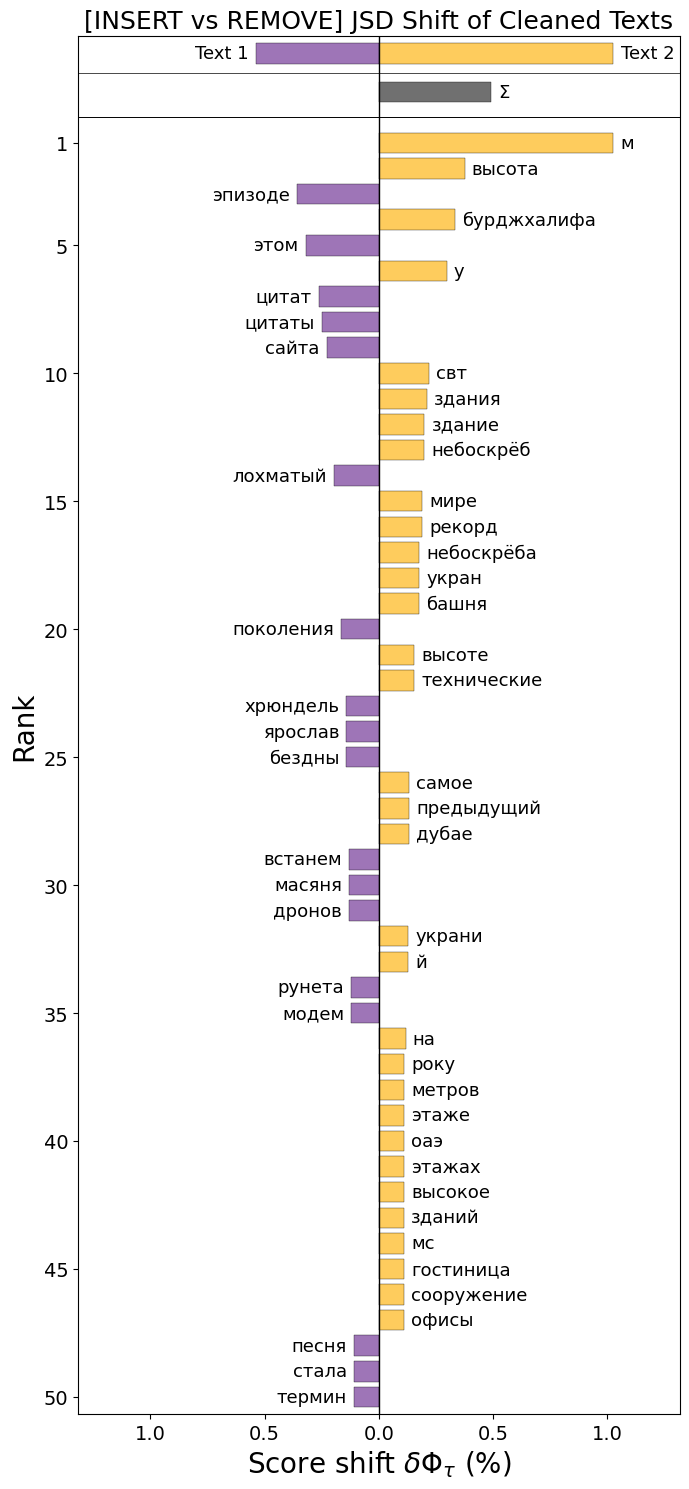

In [14]:
from collections import Counter
import shifterator as sh
import matplotlib.pyplot as plt

# Make sure 'cleaned_texts_removed_joined' exists
fp_df['cleaned_texts_removed_joined'] = fp_df['texts_removed_joined'].apply(clean_text)

# Create full joined strings for inserted and removed cleaned texts
insert_text_all = " ".join(fp_df['cleaned_text_insert_joined'].dropna())
remove_text_all = " ".join(fp_df['cleaned_texts_removed_joined'].dropna())

# Convert to word frequency dicts
type2freq_insert = dict(Counter(insert_text_all.split()))
type2freq_remove = dict(Counter(remove_text_all.split()))

# Compute JSD shift
jsd_shift_ir = sh.JSDivergenceShift(
    type2freq_1=type2freq_insert,
    type2freq_2=type2freq_remove,
    weight_1=0.5,
    weight_2=0.5,
    base=2,
)

# Plot
jsd_shift_ir.get_shift_graph(
    system_names=['Inserted Text', 'Removed Text'],
    title='[INSERT vs REMOVE] JSD Shift of Cleaned Texts',
    cumulative_inset=False,
    text_size_inset=False
)

plt.show()


In [8]:
import collections
import collections.abc
collections.Mapping = collections.abc.Mapping


/opt/conda/lib/python3.11/site-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


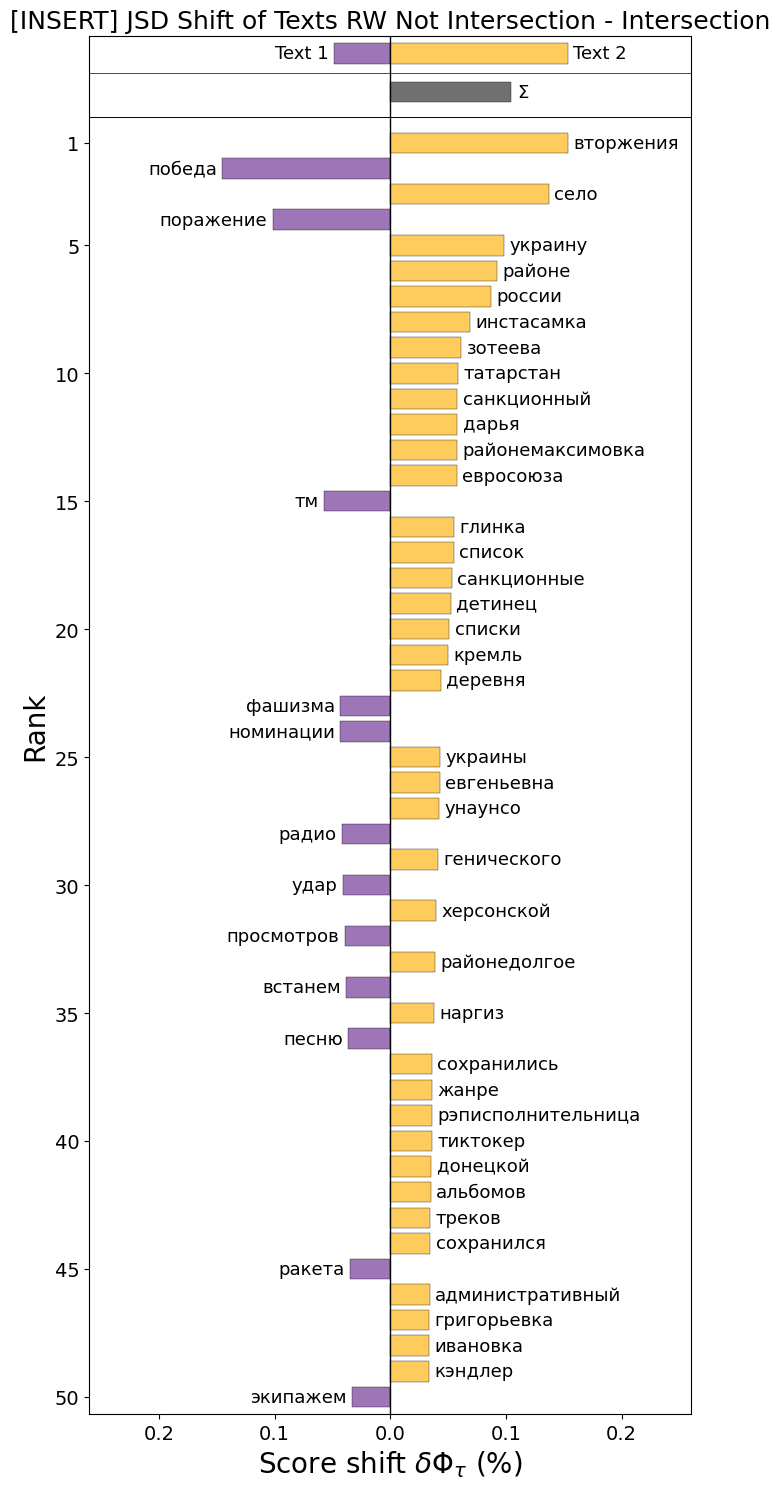

In [31]:
from collections import Counter
import shifterator as sh
import matplotlib.pyplot as plt

not_intersection = selected_ru_text.loc[
    selected_ru_text['insert_intersection_chunk'].isna()
]

intersection = selected_ru_text.loc[
    selected_ru_text['insert_intersection_chunk'].notna()
]

not_intersection_text = " ".join(not_intersection['cleaned_text_insert_joined'].dropna())
intersection_text = " ".join(intersection['cleaned_text_insert_joined'].dropna())

type2freq_1 = dict(Counter(not_intersection_text.split()))
type2freq_2 = dict(Counter(intersection_text.split()))

jsd_shift = sh.JSDivergenceShift(
    type2freq_1=type2freq_1,
    type2freq_2=type2freq_2,
    weight_1=0.5,
    weight_2=0.5,
    base=2,
    # alpha=1
)

jsd_shift.get_shift_graph(
    system_names=['Not Intersection', 'Intersection'], 
    title='[INSERT] JSD Shift of Texts RW Not Intersection - Intersection',
    cumulative_inset=False,  
    text_size_inset=False    
)

plt.show()

/opt/conda/lib/python3.11/site-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


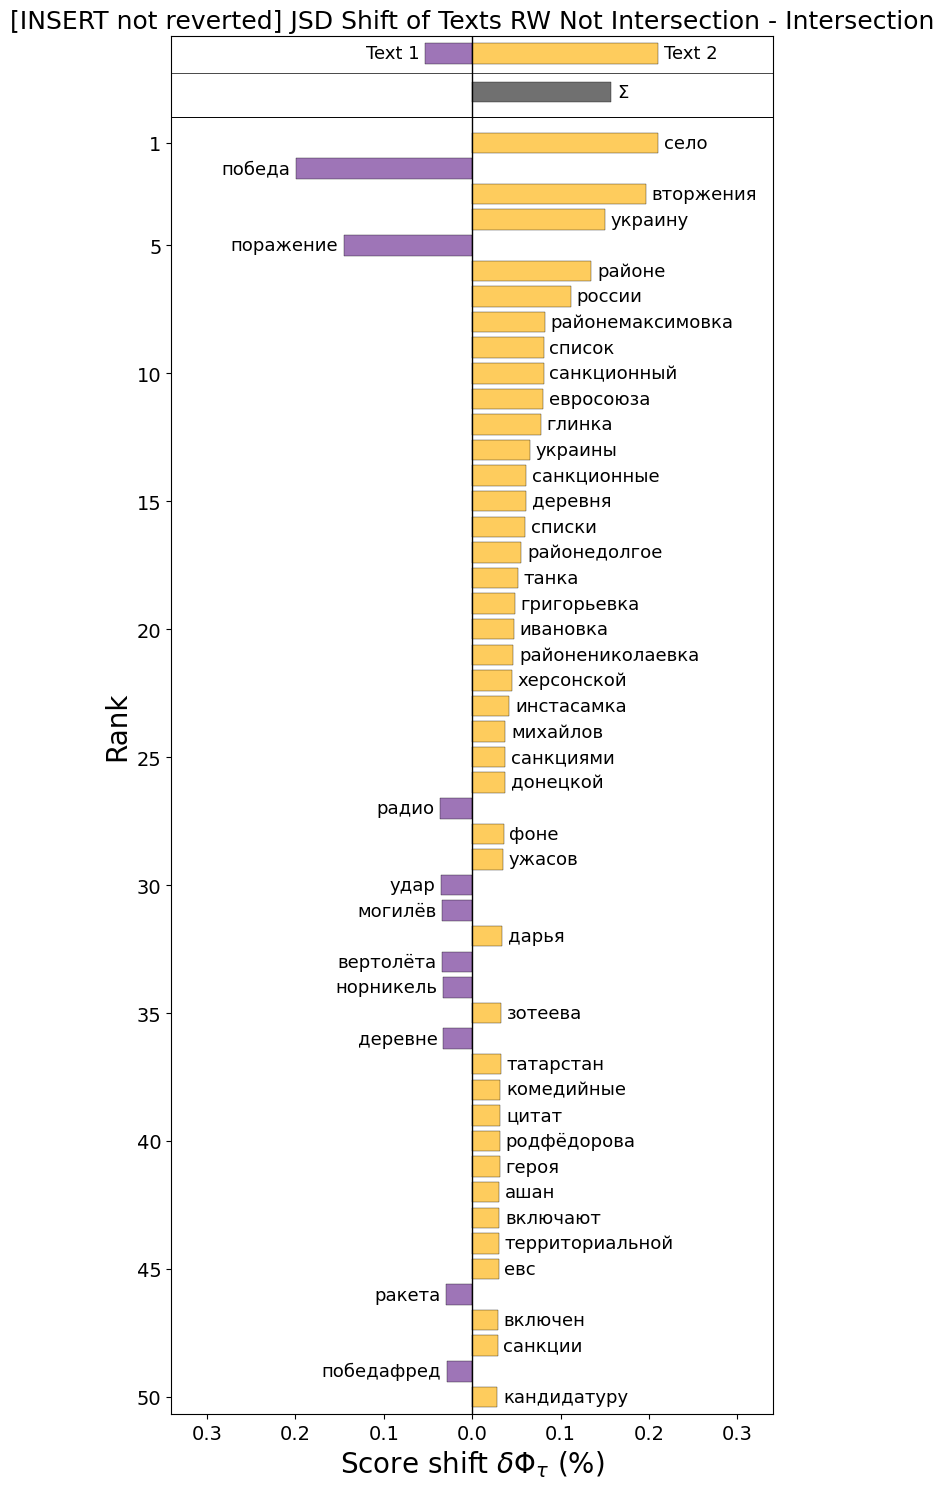

In [32]:
from collections import Counter
import shifterator as sh
import matplotlib.pyplot as plt

not_intersection = selected_ru_text.loc[
    (selected_ru_text['is_reverted'] == 0) & (selected_ru_text['insert_intersection_chunk'].isna())
]

intersection = selected_ru_text.loc[
    (selected_ru_text['is_reverted'] == 0) & (selected_ru_text['insert_intersection_chunk'].notna())
]

not_intersection_text = " ".join(not_intersection['cleaned_text_insert_joined'].dropna())
intersection_text = " ".join(intersection['cleaned_text_insert_joined'].dropna())

type2freq_1 = dict(Counter(not_intersection_text.split()))
type2freq_2 = dict(Counter(intersection_text.split()))

jsd_shift = sh.JSDivergenceShift(
    type2freq_1=type2freq_1,
    type2freq_2=type2freq_2,
    weight_1=0.5,
    weight_2=0.5,
    base=2,
    # alpha=1
)

jsd_shift.get_shift_graph(
    system_names=['Not Intersection', 'Intersection'], 
    title='[INSERT not reverted] JSD Shift of Texts RW Not Intersection - Intersection',
    cumulative_inset=False,  
    text_size_inset=False    
)

plt.show()

/opt/conda/lib/python3.11/site-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


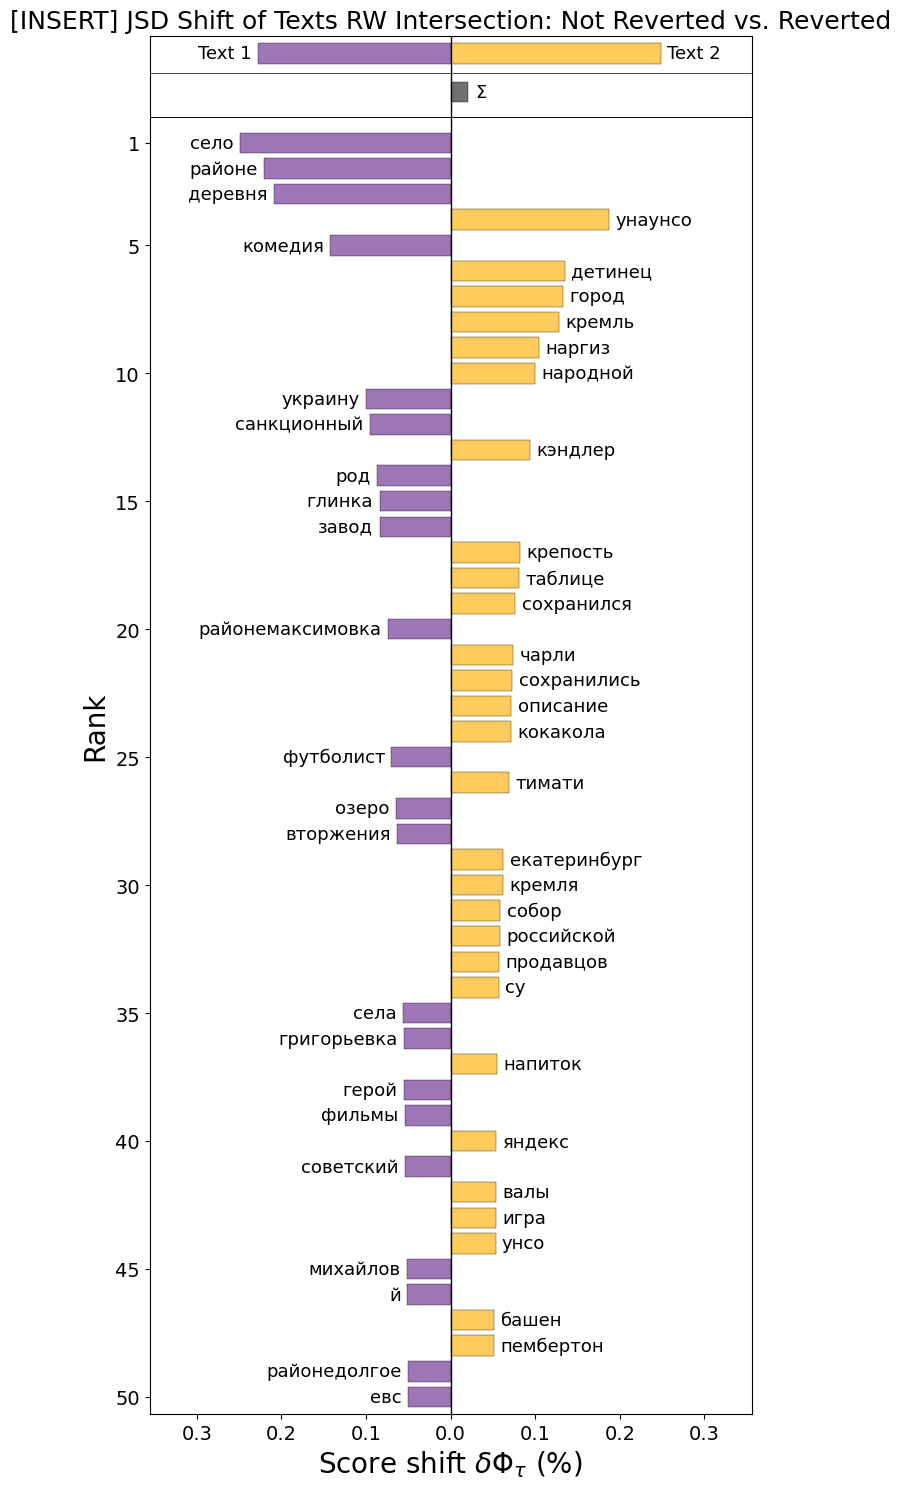

In [33]:
from collections import Counter
import shifterator as sh
import matplotlib.pyplot as plt

not_reverted_intersection = selected_ru_text.loc[
    (selected_ru_text['is_reverted'] == 0) & selected_ru_text['insert_intersection_chunk'].notna()
]

reverted_intersection = selected_ru_text.loc[
    (selected_ru_text['is_reverted'] == 1) & selected_ru_text['insert_intersection_chunk'].notna()
]

not_reverted_text = " ".join(not_reverted_intersection['cleaned_text_insert_joined'].dropna())
reverted_text = " ".join(reverted_intersection['cleaned_text_insert_joined'].dropna())

type2freq_1 = dict(Counter(not_reverted_text.split()))
type2freq_2 = dict(Counter(reverted_text.split()))

jsd_shift = sh.JSDivergenceShift(
    type2freq_1=type2freq_1,
    type2freq_2=type2freq_2,
    weight_1=0.5,
    weight_2=0.5,
    base=2,
    # alpha=1
)

jsd_shift.get_shift_graph(
    system_names=['Not Reverted', 'Reverted'], 
    title='[INSERT] JSD Shift of Texts RW Intersection: Not Reverted vs. Reverted',
    cumulative_inset=False,  
    text_size_inset=False    
)

plt.show()

Text 1 (Not Reverted) focuses more on neutral and general geographic/historical topics.

Text 2 (Reverted) introduces terms with political, military, or international significance.

Note: A large shift means these words significantly contributed to the divergence between the two versions.

/opt/conda/lib/python3.11/site-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


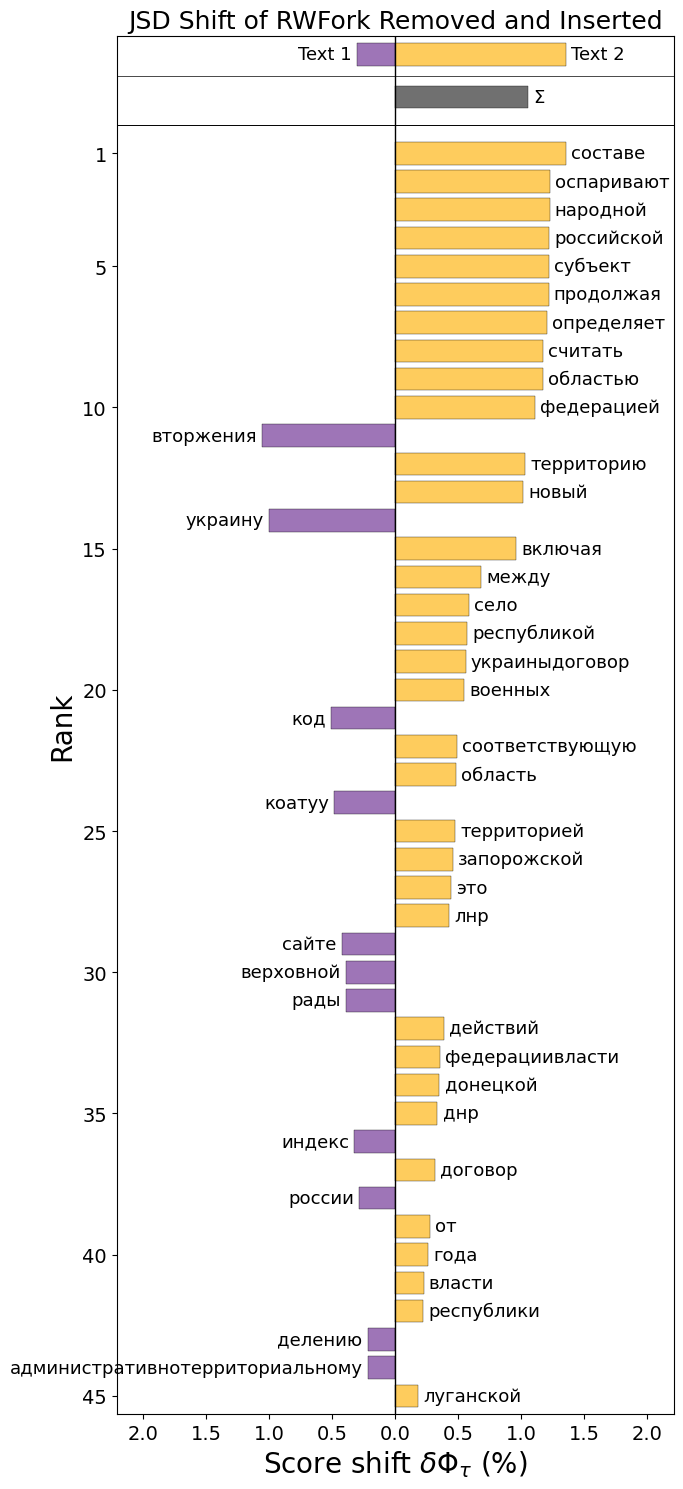

In [43]:
from collections import Counter
import shifterator as sh
import matplotlib.pyplot as plt

fork_text = fork_text.copy()

fork_text["cleaned_text_insert_joined"] = fork_text["text_insert_joined"].apply(clean_text)
fork_text["cleaned_text_removed_joined"] = fork_text["texts_removed_joined"].apply(clean_text)

removed_text_df = fork_text.loc[fork_text['cleaned_text_removed_joined'].notna()]
inserted_text_df = fork_text.loc[fork_text['cleaned_text_insert_joined'].notna()]

removed_text = " ".join(removed_text_df['cleaned_text_removed_joined'])
inserted_text = " ".join(inserted_text_df['cleaned_text_insert_joined'])

removed_freq_1 = dict(Counter(removed_text.split()))
inserted_freq_2 = dict(Counter(inserted_text.split()))

jsd_shift = sh.JSDivergenceShift(
    type2freq_1=removed_freq_1,
    type2freq_2=inserted_freq_2,
    weight_1=0.5,
    weight_2=0.5,
    base=2
)

ax = jsd_shift.get_shift_graph(
    system_names=['Removed', 'Inserted'], 
    title='JSD Shift of RWFork Removed and Inserted',
    cumulative_inset=False,  
    text_size_inset=False,
    top_n=45,
    as_pyplot_figure=True
)



fig = ax.get_figure()
fig.savefig("jsd_shift_removed_vs_inserted.pdf", bbox_inches='tight')
plt.show()

/opt/conda/lib/python3.11/site-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


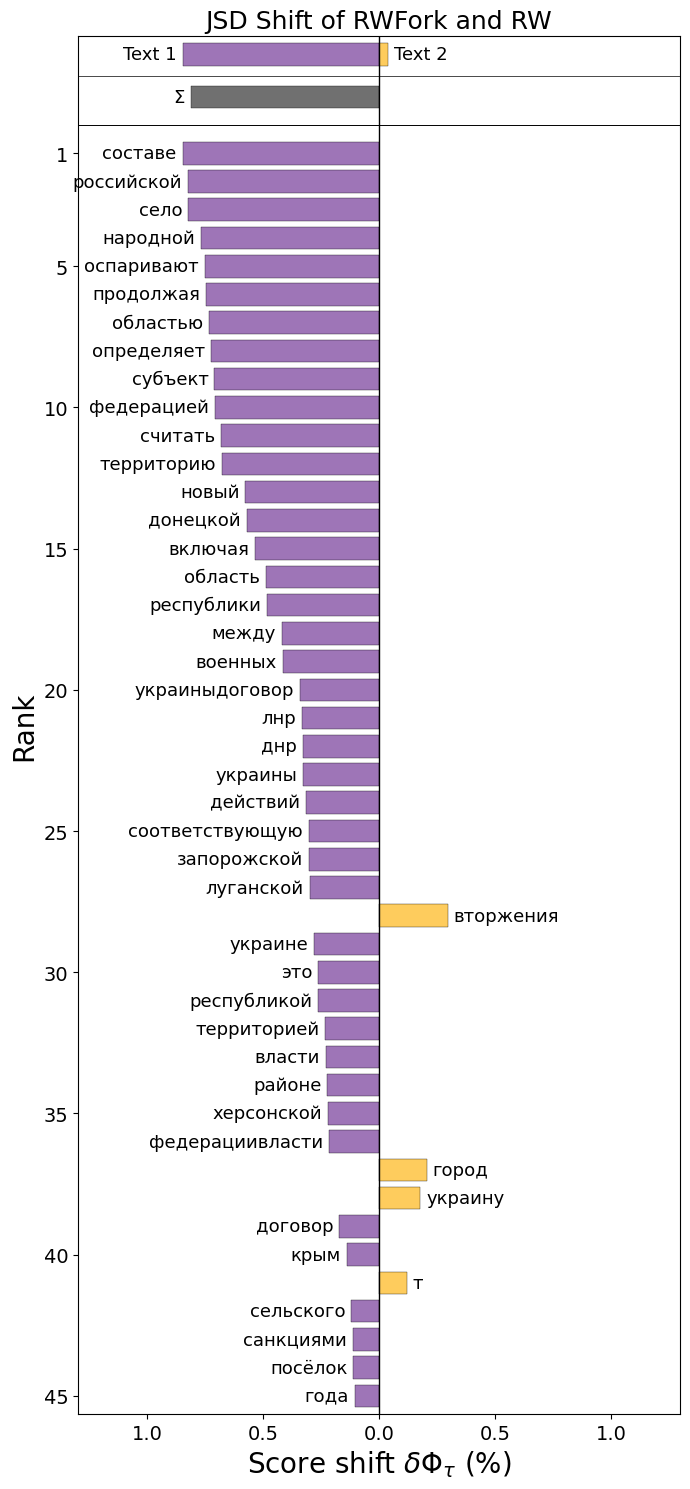

In [44]:
from collections import Counter
import shifterator as sh
import matplotlib.pyplot as plt


fork_text = fork_text.copy()
selected_ru_text = selected_ru_text.copy()

fork_text["cleaned_text_insert_joined"] = fork_text["text_insert_joined"].apply(clean_text)
selected_ru_text["cleaned_text_insert_joined"] = selected_ru_text["texts_removed_joined"].apply(clean_text)

fork_text_df = fork_text.loc[fork_text['cleaned_text_insert_joined'].notna()]
selected_ru_text_df = selected_ru_text.loc[selected_ru_text['cleaned_text_insert_joined'].notna()]

fork_inserted_text = " ".join(fork_text_df['cleaned_text_insert_joined'])
ru_inserted_text = " ".join(selected_ru_text_df['cleaned_text_insert_joined'])

fork_inserted_freq_1 = dict(Counter(fork_inserted_text.split()))
ru_inserted_freq_2 = dict(Counter(ru_inserted_text.split()))

jsd_shift = sh.JSDivergenceShift(
    type2freq_1=fork_inserted_freq_1,
    type2freq_2=ru_inserted_freq_2,
    weight_1=0.5,
    weight_2=0.5,
    base=2 
)


ax = jsd_shift.get_shift_graph(
    system_names=['RWFork', 'RW'], 
    title='JSD Shift of RWFork and RW',
    cumulative_inset=False,  
    text_size_inset=False,
    top_n=45,
    as_pyplot_figure=True
)

fig = ax.get_figure()
fig.savefig("jsd_shift_rw_rwf.pdf", bbox_inches='tight')
plt.show()

/opt/conda/lib/python3.11/site-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


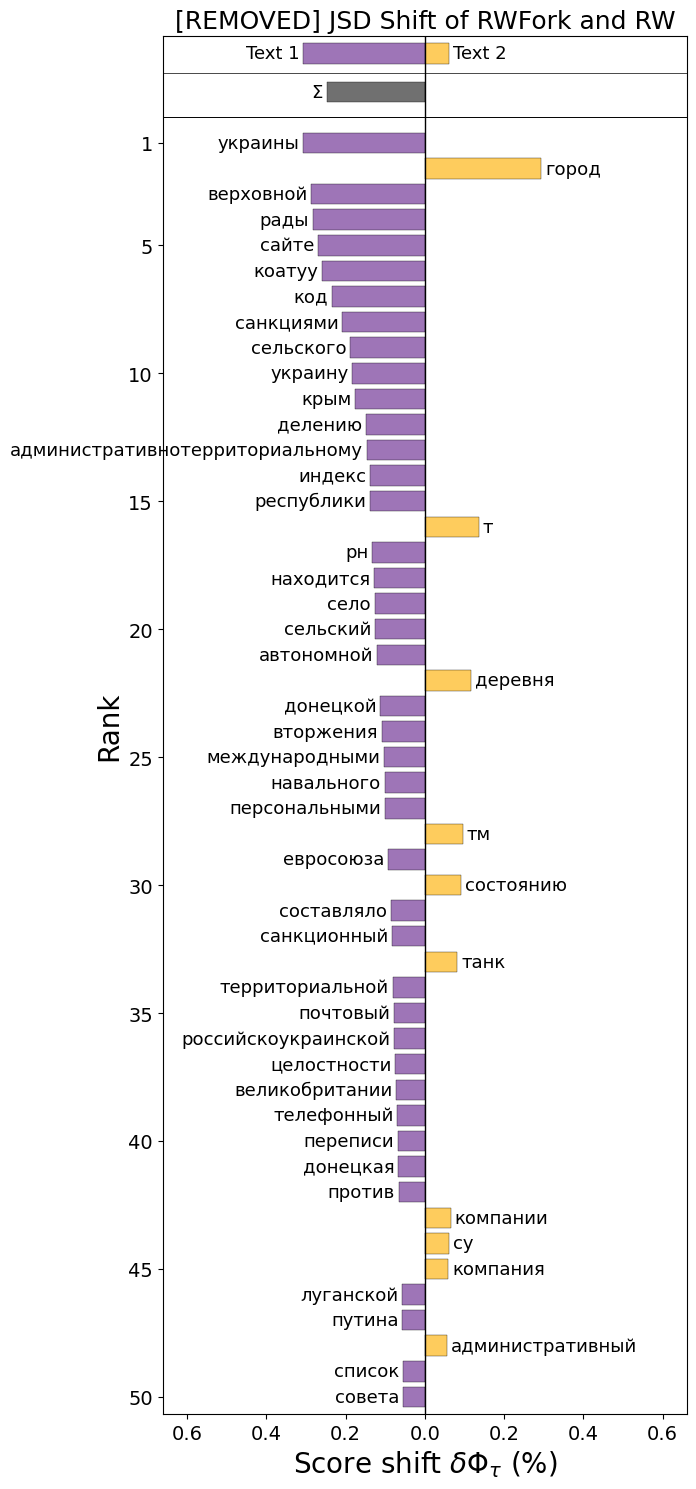

In [36]:
from collections import Counter
import shifterator as sh
import matplotlib.pyplot as plt


fork_text = fork_text.copy()
selected_ru_text = selected_ru_text.copy()

fork_text["cleaned_text_removed_joined"] = fork_text["texts_removed_joined"].apply(clean_text)
selected_ru_text["cleaned_text_removed_joined"] = selected_ru_text["texts_removed_joined"].apply(clean_text)

fork_text_df = fork_text.loc[fork_text['cleaned_text_removed_joined'].notna()]
selected_ru_text_df = selected_ru_text.loc[selected_ru_text['cleaned_text_removed_joined'].notna()]

fork_inserted_text = " ".join(fork_text_df['cleaned_text_removed_joined'])
ru_inserted_text = " ".join(selected_ru_text_df['cleaned_text_removed_joined'])

fork_inserted_freq_1 = dict(Counter(fork_inserted_text.split()))
ru_inserted_freq_2 = dict(Counter(ru_inserted_text.split()))

jsd_shift = sh.JSDivergenceShift(
    type2freq_1=fork_inserted_freq_1,
    type2freq_2=ru_inserted_freq_2,
    weight_1=0.5,
    weight_2=0.5,
    base=2 
)


jsd_shift.get_shift_graph(
    system_names=['RWFork', 'RW'], 
    title='[REMOVED] JSD Shift of RWFork and RW',
    cumulative_inset=False,  
    text_size_inset=False    
)

plt.show()